# 準備

In [1]:
import getpass
import os

# # OpenAI API キーの設定
# api_key = getpass.getpass("OpenAI API キーを入力してください: ")

from dotenv import load_dotenv
load_dotenv(dotenv_path="/home/rmasuda/book-llm-agent/.env")

api_key=os.getenv(key="OPENAI_API_KEY")

os.environ["OPENAI_API_KEY"] = api_key

# 2.1 OpenAI API

## 2.1.1 テキスト生成の基礎

In [3]:
# テキスト生成の基本的な流れ

from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    temperature=0.0,
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "こんにちは"}],
)

print(response.choices[0].message.content)

こんにちは！どういったことをお手伝いできますか？


In [3]:
# シンプルな対話 AI の作成

history = []
n = 10  # 会話の上限
model = "gpt-4o-mini"
for _ in range(n):
    user_input = input("ユーザ入力: ")
    if user_input == "exit":
        break
    print(f"ユーザ: {user_input}")
    history.append({"role": "user", "content": user_input})
    response = client.chat.completions.create(model=model, messages=history)
    content = response.choices[0].message.content
    print(f"AI: {content}")
    history.append({"role": "assistant", "content": content})

## 2.1.2 テキスト生成の応用

### Stream Generation

In [ ]:
# 生成できた部分から順に表示する

history = []
n = 10  # 会話の上限
model = "gpt-4o-mini"
for _ in range(n):
    user_input = input("ユーザ入力: ")
    if user_input == "exit":
        break
    print(f"ユーザ: {user_input}")
    history.append({"role": "user", "content": user_input})
    # stream=True でストリーミングを有効化
    stream = client.chat.completions.create(model=model, messages=history, stream=True)
    print("AI: ", end="")
    # 応答を集める文字列
    ai_content = ""
    # ストリーミングの各チャンクを処理
    for chunk in stream:
        # message ではなく ChoiceDelta
        content = chunk.choices[0].delta.content
        # ChoiceDelta の finish_reason が stop なら生成完了
        if chunk.choices[0].finish_reason == "stop":
            break
        print(content, end="")
        ai_content += content
    print()
    history.append({"role": "assistant", "content": ai_content})

### Function Calling

In [ ]:
# 最大公約数を求めるツールの利用

gcd_function = {
    "name": "gcd",
    "description": "最大公約数を求める",
    "parameters": {
        "type": "object",
        "properties": {
            "num1": {"type": "number", "description": "整数1"},
            "num2": {"type": "number", "description": "整数2"},
        },
        "required": ["num1", "num2"],
    },
}
tools = [{"type": "function", "function": gcd_function}]

messages = [
    {"role": "user", "content": "50141 と 53599 の最大公約数を求めてください。"}
]

response = client.chat.completions.create(
    model="gpt-4o-mini", messages=messages, tools=tools
)
print(response.choices[0].message.content)  # None
print(response.choices[0].finish_reason)  # tool_calls
print(response.choices[0].message.tool_calls)  # [ChatCompletionMessageToolCall(...)]


In [18]:
# 関数情報を抽出

import json

function_info = response.choices[0].message.tool_calls[0].function
name = function_info.name
args = json.loads(function_info.arguments)

In [ ]:
# 最大公約数の計算

import math

print(math.gcd(args["num1"], args["num2"]))

In [20]:
# Pydantic を用いた関数の定義

from pydantic import BaseModel, Field


class GCD(BaseModel):
    num1: int = Field(description="整数1")
    num2: int = Field(description="整数2")


gcd_function = {
    "name": "gcd",
    "description": "最大公約数を求める",
    "parameters": GCD.model_json_schema(),
}

In [21]:
tools = [{"type": "function", "function": gcd_function}]

messages = [
    {"role": "user", "content": "50141 と 53599 の最大公約数を求めてください。"}
]

response = client.chat.completions.create(
    model="gpt-4o-mini", messages=messages, tools=tools
)

In [ ]:
# Pydantic を用いた引数の取得

parsed_result = GCD.model_validate_json(
    response.choices[0].message.tool_calls[0].function.arguments
)
print(parsed_result)

In [ ]:
# ツール利用全体の流れ


class LCM(BaseModel):
    num1: int = Field(description="整数1")
    num2: int = Field(description="整数2")


lcm_function = {
    "name": "lcm",
    "description": "最小公倍数を求める",
    "parameters": LCM.model_json_schema(),
}

tools = [
    {"type": "function", "function": gcd_function},
    {"type": "function", "function": lcm_function},
]

messages = [
    {
        "role": "user",
        "content": "50141 と 53599 の最大公約数と最小公倍数を求めてください。",
    }
]

response = client.chat.completions.create(
    model="gpt-4o-mini", messages=messages, tools=tools
)
choice = response.choices[0]
if choice.finish_reason == "tool_calls":
    for tool in choice.message.tool_calls:
        if tool.function.name == "gcd":
            gcd_args = GCD.model_validate_json(tool.function.arguments)
            print(f"最大公約数: {math.gcd(gcd_args.num1, gcd_args.num2)}")
        elif tool.function.name == "lcm":
            lcm_args = LCM.model_validate_json(tool.function.arguments)
            print(f"最小公倍数: {math.lcm(lcm_args.num1, lcm_args.num2)}")
elif choice.finish_reason == "stop":
    print("AI: ", choice.message.content)

### response_format

In [ ]:
# response_format の利用例


class Translations(BaseModel):
    english: str = Field(description="英語の文章")
    french: str = Field(description="フランス語の文章")
    chinese: str = Field(description="中国語の文章")


prompt = f"""\
以下に示す文章を英語・フランス語・中国語に翻訳してください。
ただし、アウトプットは後述するフォーマットの JSON 形式で出力してください。

# 文章
吾輩は猫である。名前はまだない。

# 出力フォーマット
以下に JSON Schema 形式のフォーマットを示します。このフォーマットに従うオブジェクトの形で出力してください。
{Translations.model_json_schema()}
"""

response = client.chat.completions.create(
    temperature=0.0,
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={"type": "json_object"},
)

translations = Translations.model_validate_json(response.choices[0].message.content)
print("英語:", translations.english)
print("フランス語:", translations.french)
print("中国語:", translations.chinese)

In [ ]:
prompt = """\
以下に示す文章を英語・フランス語・中国語に翻訳してください。
ただし、アウトプットは後述するフォーマットの JSON 形式で出力してください。

# 文章
吾輩は猫である。名前はまだない。

# 出力フォーマット
JSON Schema に従う形式で出力してください。
"""

response = client.beta.chat.completions.parse(
    temperature=0.0,
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format=Translations,
)
translations = response.choices[0].message.parsed

print("英語:", translations.english)
print("フランス語:", translations.french)
print("中国語:", translations.chinese)

# 2.1.3 画像を入力する

In [2]:
import base64
from pathlib import Path
from typing import Any

from openai import OpenAI

client = OpenAI()


def image2content(image_path: Path) -> dict[str, Any]:
    # base64 エンコード
    with image_path.open("rb") as f:
        image_base64 = base64.b64encode(f.read()).decode("utf-8")

    # content の作成
    content = {
        "type": "image_url",
        "image_url": {"url": f"data:image/png;base64,{image_base64}", "detail": "low"},
    }
    return content

{'type': 'image_url', 'image_url': {'url': '', 'detail': 'low'}}
これは猫のイラストのようです。シンプルな線画で、猫の顔と体が描かれています。

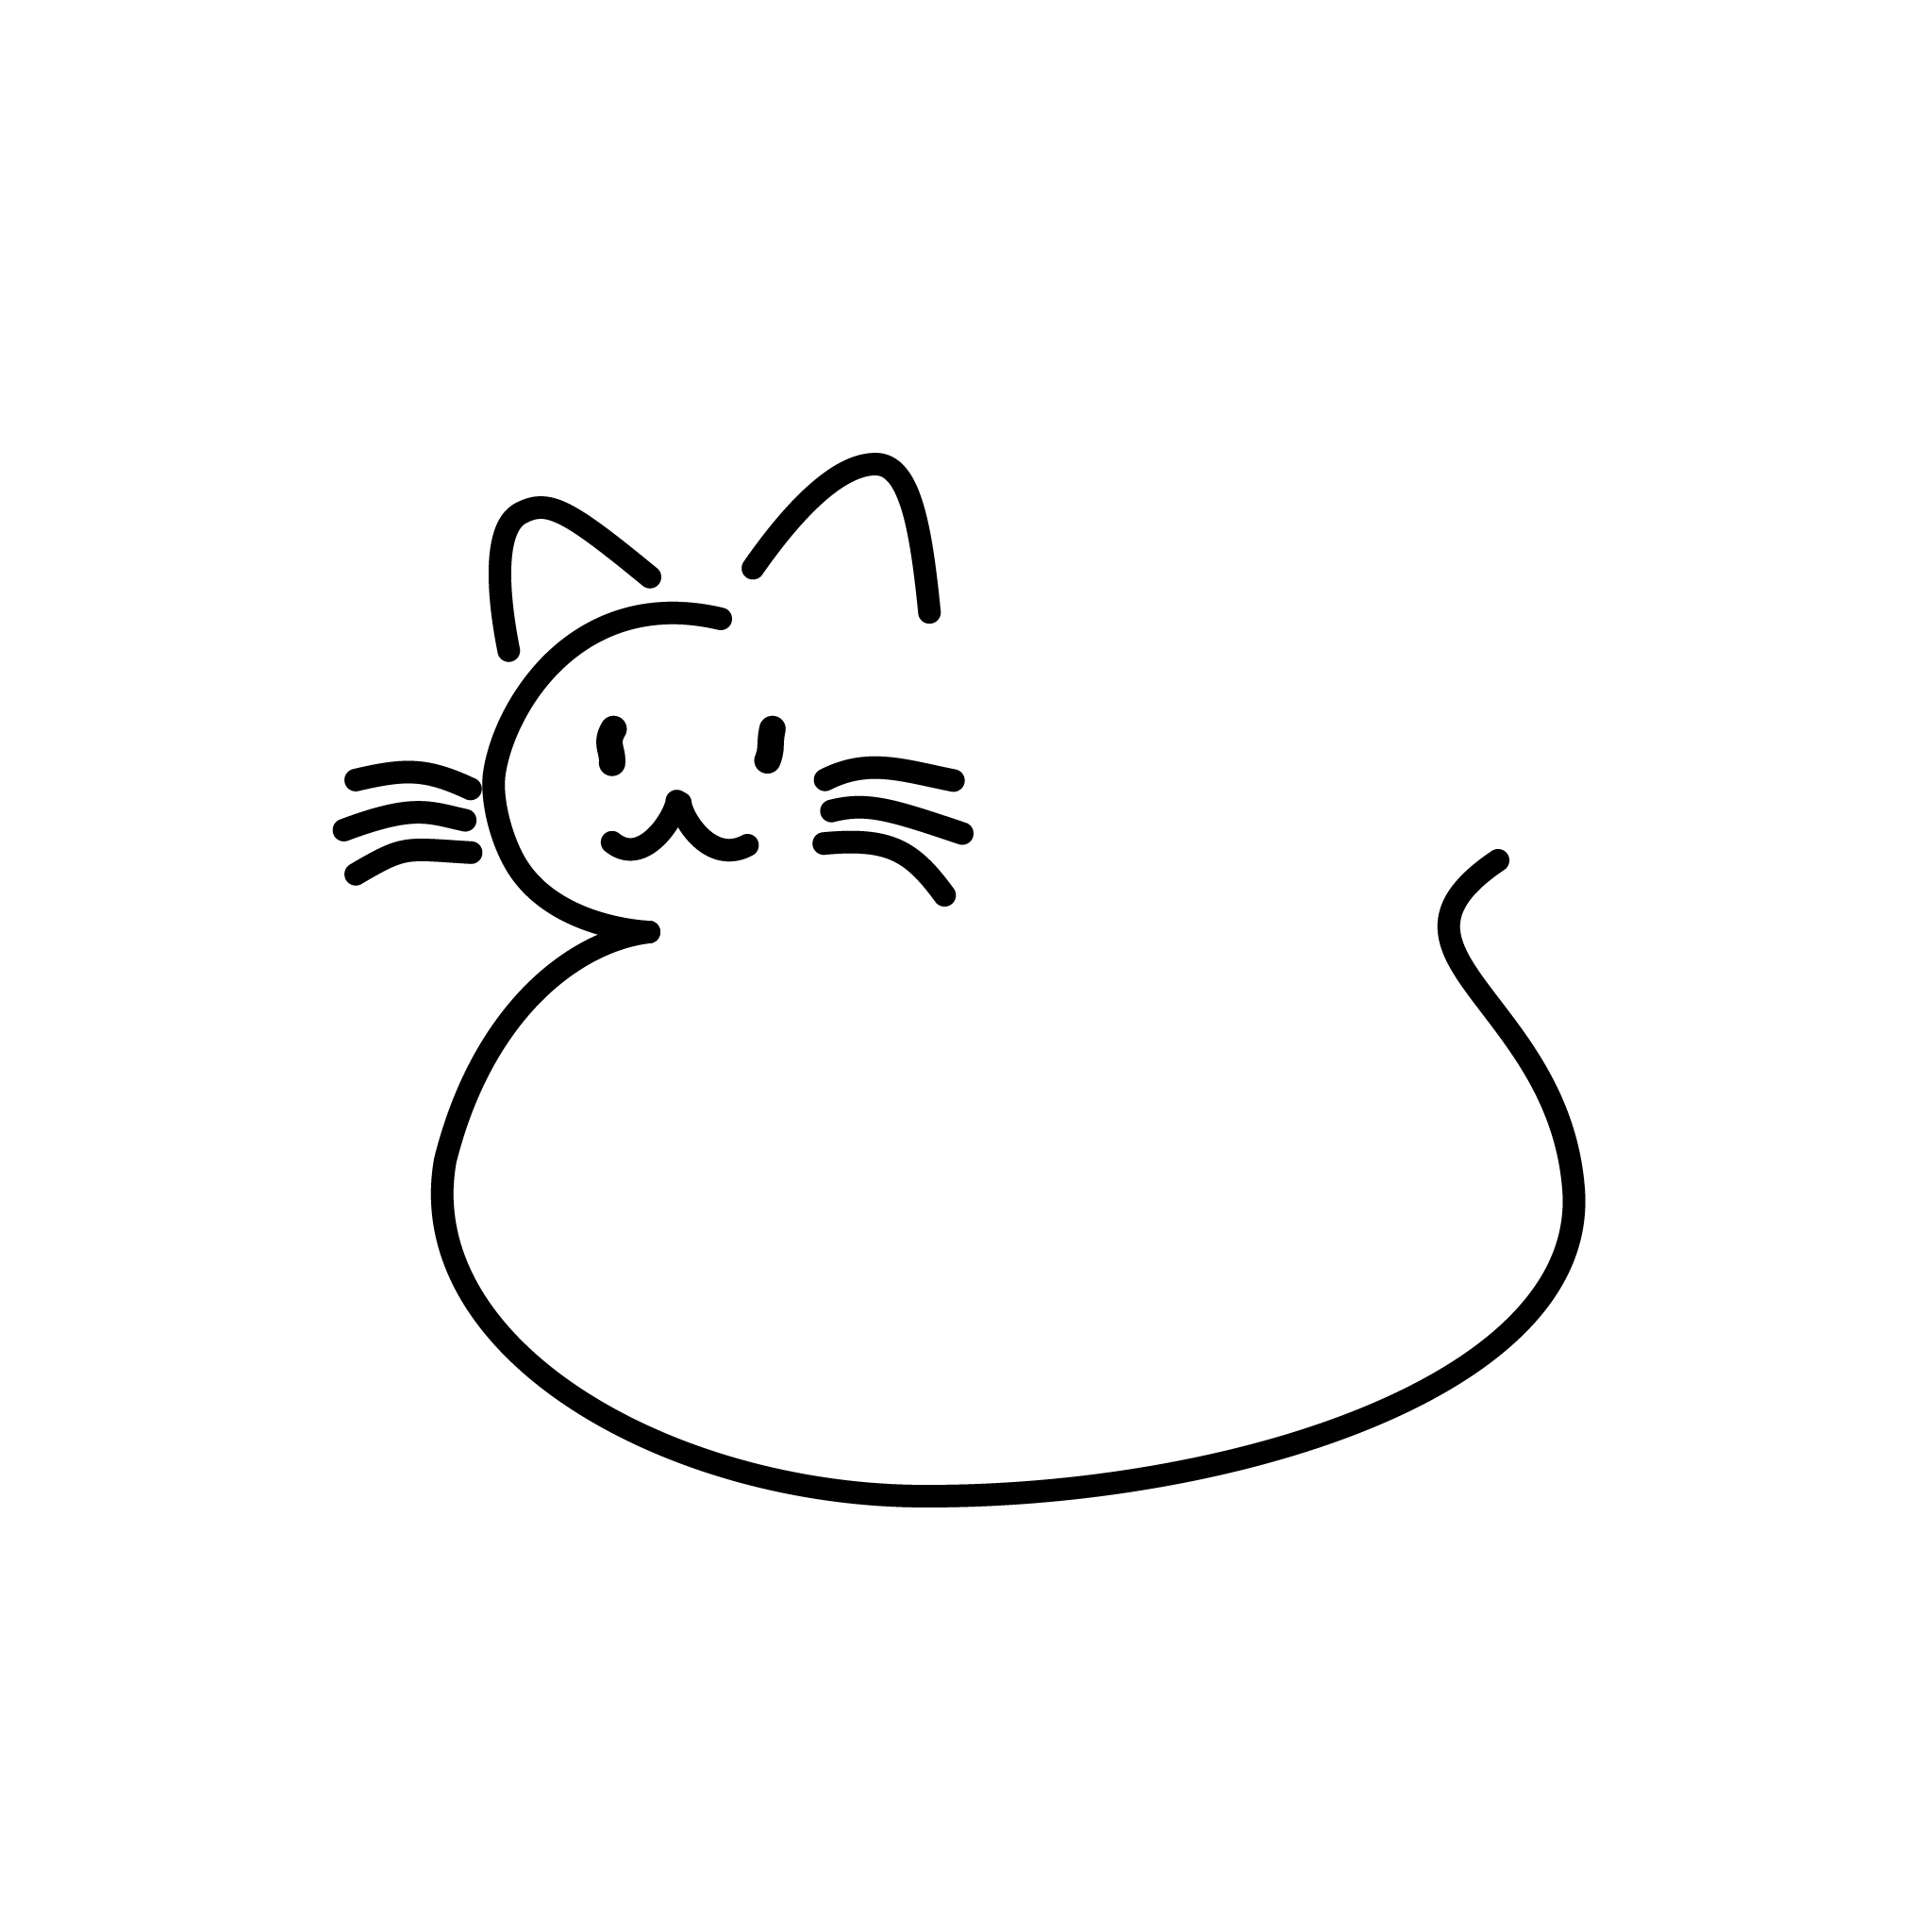

In [3]:
prompt = "これは何の画像ですか?"
image_path = Path("./sample_image1.png")
contents = [{"type": "text", "text": prompt}, image2content(image_path)]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.0,
    messages=[{"role": "user", "content": contents}],
)

print(response.choices[0].message.content)

{'type': 'image_url', 'image_url': {'url': '', 'detail': 'low'}}
{'type': 'image_url', 'image_url': {'url': '', 'detail': 'low'}}
2枚の画像の違いは以下の通りです：

1. **スタイル**:
   - 最初の画像はシンプルで線画スタイルの猫のイラストです。
   - 2枚目の画像はカラフルで詳細なイラストで、猫が帽子をかぶっているデザインです。

2. **色彩**:
   - 最初の画像はモノクロで、色が使われていません。
   - 2枚目の画像は白い猫と背景に青とピンクの色が使われています。

3. **表現**:
   - 最初の画像は抽象的で、猫の特徴を簡潔に表現しています。
   - 2枚目の画像は猫の表情やポーズがより詳細で、可愛らしさが強調されています。

これらの違いにより、2つの画像は異なる印象を与えます。

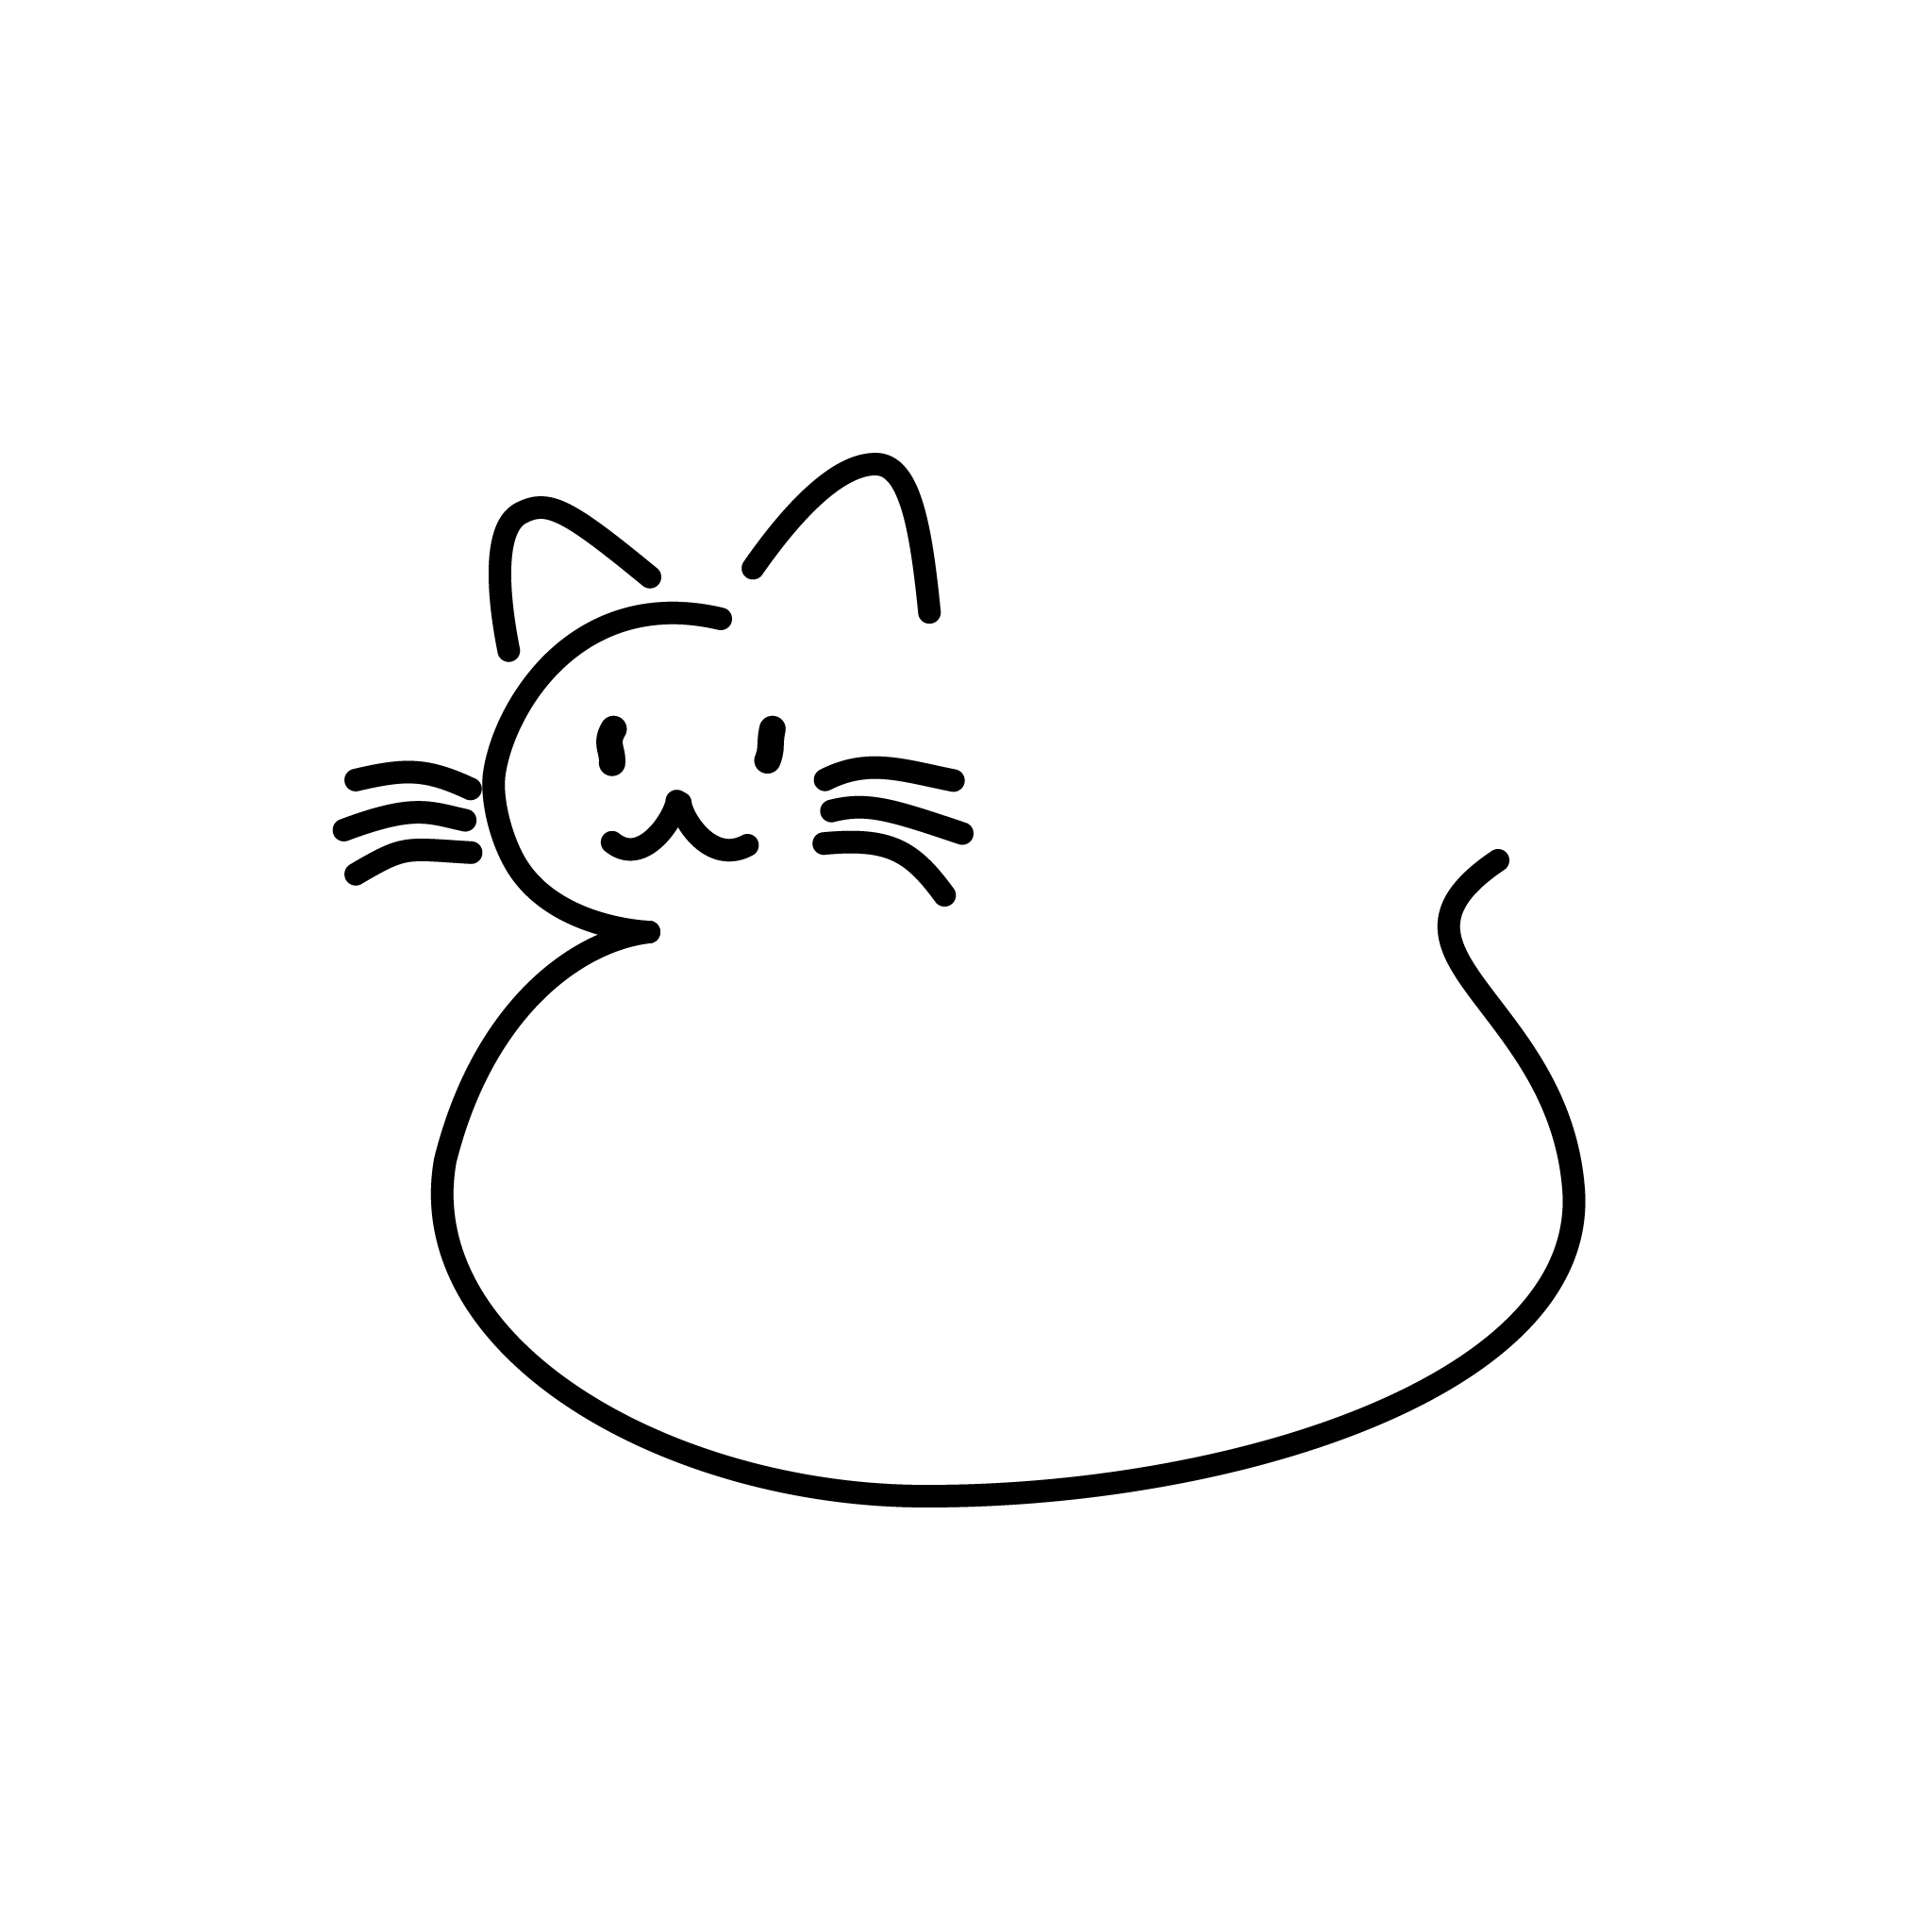
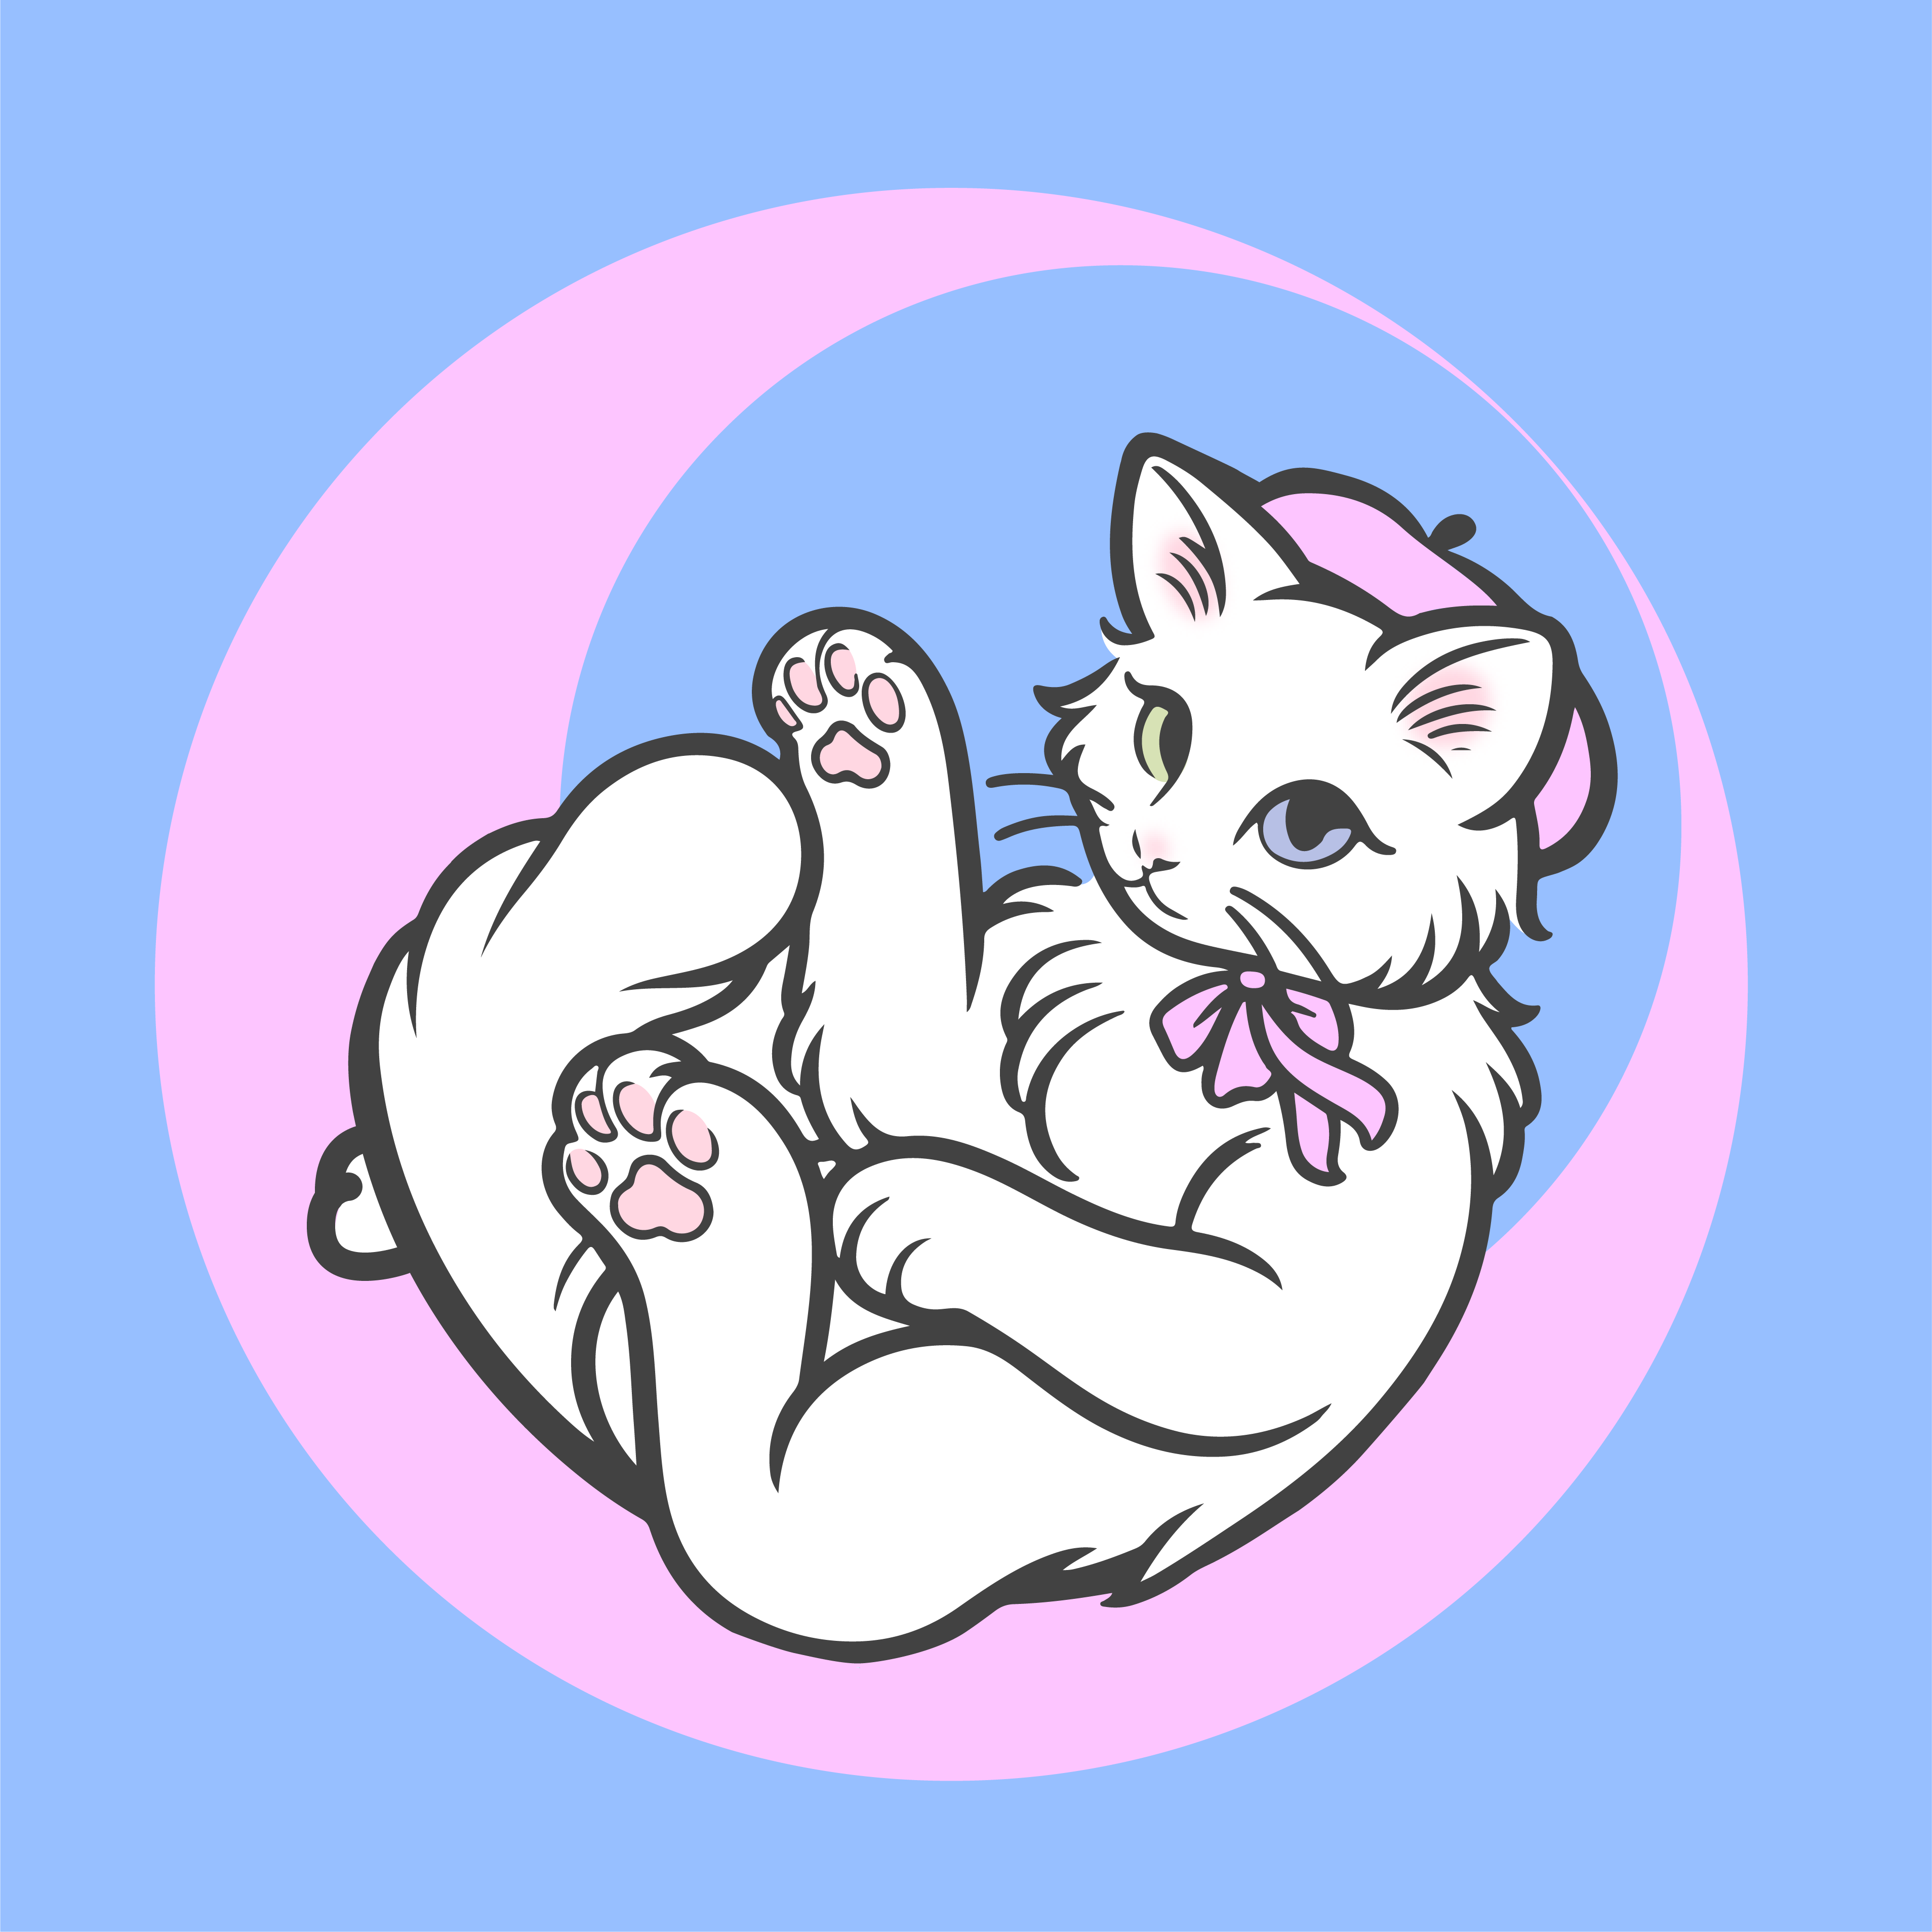

In [4]:
image_path2 = Path("./sample_image2.png")

prompt = "2枚の画像の違いを教えてください。"
contents = [
    {"type": "text", "text": prompt},
    image2content(image_path),
    image2content(image_path2),
]
response = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.0,
    messages=[{"role": "user", "content": contents}],
)

print(response.choices[0].message.content)

# 2.1.4 音声を扱う

音声を文字起こしする。

In [5]:
from pathlib import Path

from openai import OpenAI


client = OpenAI()
audio_path = Path("./sample_audio.mp3")

with audio_path.open("rb") as f:
    transcription = client.audio.transcriptions.create(
        model="whisper-1", file=f, temperature=0.0
    )
print(transcription.text)

私の名前は下ヶ内です。


プロンプトを用いて文字起こしする。

In [6]:
prompt = "下垣内"

with audio_path.open("rb") as f:
    transcription = client.audio.transcriptions.create(
        model="whisper-1",
        file=f,
        prompt=prompt,
        response_format="text",
        temperature=0.0,
    )
print(transcription)

私の名前は下垣内です。



音声を合成する。

In [8]:
audio_output_path = Path("output.mp3")
with client.audio.speech.with_streaming_response.create(
    model="tts-1",
    voice="alloy",
    input="こんにちは。私は AI アシスタントです！",
) as response:
    response.stream_to_file(audio_output_path)

# 2.1.5 画像を生成する

In [9]:
from openai import OpenAI
import requests

client = OpenAI()

prompt = """\
メタリックな球体
"""

response = client.images.generate(
    model="dall-e-3", prompt=prompt, n=1, size="1024x1024"
)

image_url = response.data[0].url
image = requests.get(image_url).content
with open("output1.png", "wb") as f:
    f.write(image)

In [10]:
response = client.images.generate(
    model="dall-e-3", prompt=prompt, n=1, size="1024x1024", response_format="b64_json"
)

image = response.data[0].b64_json

with open("output2.png", "wb") as f:
    f.write(base64.b64decode(image))

In [ ]:
print(response.data[0].revised_prompt)